# Sparse Bayes Model

Let's model the data as arising from a generative model in which the log firing rates factorize.

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

## Exploratory analysis

In [2]:
dat = pd.read_csv('data/prepared_data.csv')

In [3]:
dat.shape

(687276, 7)

In [5]:
dat.head(10)

,stim,unit,isfirst,isrewarded,count,trial,time
0,0,1068,0,0,4,57277,0
1,0,1069,0,0,1,57277,0
2,0,1070,0,0,6,57277,0
3,0,1071,0,0,0,57277,0
4,0,1072,1,0,3,60250,0
5,0,1073,1,0,1,60250,0
6,0,1074,1,0,3,60250,0
7,0,1075,0,0,2,61200,0
8,0,1076,0,0,1,61200,0
9,0,1077,0,0,1,66732,0


In [11]:
dat.groupby(['trial', 'unit']).count().sum()  # only one observation of each unit on each trial

stim          687276
isfirst       687276
isrewarded    687276
count         687276
time          687276
dtype: int64

# Subset data?

In [45]:
subset = True

if subset:
    sdat = dat[(dat.unit < 5000) & (dat.stim < 400)]
else:
    sdat = dat.copy()

In [46]:
mean_count = sdat.groupby(['stim', 'unit'])['count'].mean().unstack()
mean_count.head()

unit,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268
stim,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,3.0,5.0,0.0,0.00,4.0,1.00,5.000000,0.5
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,7.0,0.0,0.20,2.8,1.40,7.000000,1.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.25,2.0,0.25,5.666667,2.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,6.0,0.0,0.00,1.5,0.00,5.500000,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,1.0,6.0,0.0,0.00,6.0,2.50,10.500000,2.0


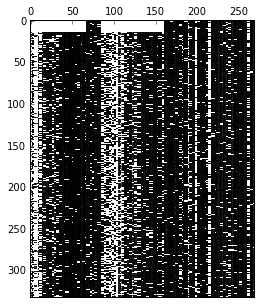

In [47]:
plt.matshow(mean_count, 'aspect=auto', cmap='gray')

In [48]:
S, U = mean_count.shape
N, _ = sdat.shape
print("stims: {}, units: {}, observations: {}".format(S, U, N))

stims: 332, units: 268, observations: 171500


# Set up Stan

In [20]:
import pystan

In [71]:
K = 5  # number of possible features
unit = np.unique(sdat.unit.values, return_inverse=True)[1] + 1
stim = np.unique(sdat.stim.values, return_inverse=True)[1] + 1
spk_dat = {'count': sdat['count'], 'unit': unit, 'stim': stim, 'U': U, 'S': S, 'N': N, 'K': K}

In [55]:
sm = pystan.StanModel(file='factor.stan')

In [72]:
fit = sm.sampling(data=spk_dat, iter=200, thin=1, chains=4,
                      seed=12345,
                      pars=['W', 'V'])

In [73]:
def get_summ_df(fit, var):
    summ = fit.summary(var)
    return pd.DataFrame(summ['summary'], index=summ['summary_rownames'], columns=summ['summary_colnames'])

In [75]:
W = get_summ_df(fit, 'W')

In [76]:
W

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
"W[0,0]",-1.253259,1.176976,1.664496,-4.040910,-2.974529,-0.901596,-0.044389,0.468113,2.0,8.373637
"W[1,0]",1.619132,2.539228,3.591011,-1.328623,-1.328623,0.213474,4.832086,7.744968,2.0,23.267086
"W[2,0]",-1.655839,2.539037,3.590740,-7.700947,-5.527723,-0.364508,1.485243,1.625167,2.0,14.528958
"W[3,0]",-2.648876,1.884706,2.665377,-5.354243,-5.312939,-3.033891,-0.013611,0.189774,2.0,25.425308
"W[4,0]",0.844346,0.881689,1.246897,-0.020952,0.155548,0.199048,1.760371,2.997811,2.0,44.989760
"W[5,0]",4.044760,5.167043,7.307302,-1.571808,-0.057635,0.049889,9.362853,16.666582,2.0,29.139277
"W[6,0]",0.369796,1.038778,2.544475,-1.242982,-0.709253,-0.054829,-0.003048,9.809259,6.0,1.682267
"W[7,0]",-0.345529,0.293563,0.415161,-1.013479,-1.013479,-0.162566,-0.075390,0.014778,2.0,3.033510
"W[8,0]",-0.483779,1.123726,1.589189,-3.187315,-2.079714,0.486053,0.646812,0.655178,2.0,25.097761
"W[9,0]",-1.029553,2.071541,2.929601,-5.963067,-3.508615,0.561471,0.655430,2.777187,2.0,5.234772


In [77]:
def plot_coeffs(df, sorted=False, transform=None):
    fig = plt.figure()
    if transform:
        b_m = transform(df['mean'])
        b_lo = b_m - transform(df['2.5%'])
        b_hi = transform(df['97.5%']) - b_m
    else:
        b_m = df['mean']
        b_lo = b_m - df['2.5%']
        b_hi = df['97.5%'] - b_m

    if len(b_m) > 1:
        if sorted:
            idx = np.argsort(b_m)
        else:
            idx = np.arange(len(b_m))

        b_m, b_lo, b_hi = b_m[idx], b_lo[idx], b_hi[idx]

        contains_1 = (df['2.5%'][idx] < 0) & (df['97.5%'][idx] > 0)
        
    else:
        contains_1 = (df['2.5%'] < 0) & (df['97.5%'] > 0)
    
    plt.errorbar(np.arange(len(b_m)), b_m, yerr=[b_lo, b_hi], capthick=0, 
                 marker='o', linestyle='None')

    # plot "significant" coefficients in red
    
    sigs = np.where(~contains_1)[0]
    plt.errorbar(sigs, b_m[sigs], yerr=[b_lo[sigs], b_hi[sigs]], capthick=0, 
                 marker='o', linestyle='None', color='red')

    plt.axhline(1., color='k', zorder=-1)
    plt.xlim(-1, len(b_m) + 1)
    
    return fig

<IPython.core.display.Javascript object>


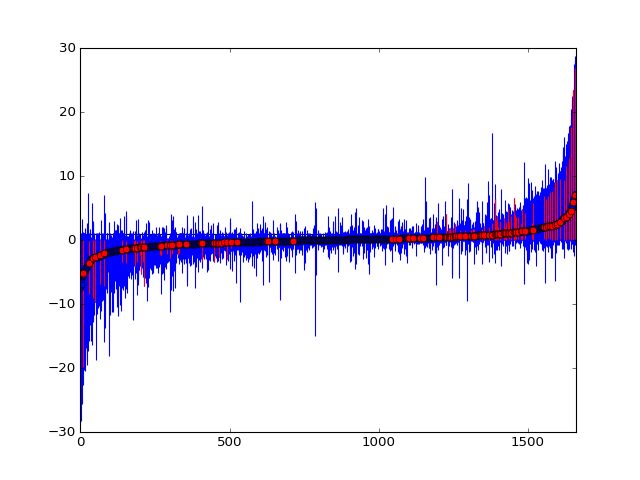

In [81]:
plot_coeffs(W, sorted=True);